In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import random
import plotly.offline
import plotly.express as px
import folium
import plotly.graph_objects as go
from datetime import timedelta
from folium import plugins
from folium.plugins import HeatMapWithTime

In [66]:
# Loading files do dfs
patInf = pd.read_csv('data/PatientInfo.csv')
govMeas = pd.read_excel('data/govmeas.xlsx')
timedf = pd.read_csv('data/Time.csv')
patRou = pd.read_csv('data/PatientRoute.csv')

In [3]:
timedf['date'] = pd.to_datetime(timedf['date'], format='%Y-%m-%d')
patInf['confirmed_date'] = pd.to_datetime(patInf['confirmed_date'], format='%Y-%m-%d')
patInf = patInf.rename(columns={'confirmed_date':'date'}) 

In [4]:
# Setting the days after the first test
timedf['days_since0'] = timedf['date'].apply(lambda x: (x-timedf.date.min()).days)

In [5]:
# Obtaining daily values from cumulative values
timedf['conf_on_day'] = timedf['confirmed'].diff().fillna(timedf['confirmed'])
timedf['test_on_day'] = timedf['test'].diff().fillna(timedf['test'])
timedf['neg_on_day'] = timedf['negative'].diff().fillna(timedf['negative'])
timedf['dec_on_day'] = timedf['deceased'].diff().fillna(timedf['deceased'])
timedf['rel_on_day'] = timedf['released'].diff().fillna(timedf['released'])

# COVID-19 in South Korea

## "Big numbers"

Before we start doing any sort of reasoning on why or how things happen the way they do, let's try to give you some context by showing the usually media-loved big numbers about COVID-19 in South Korea. The plot below is interactive! Select on the drop-down menu on the left if you would like to see the cumulative or the daily numbers for tested population, and hover your mouse over the image to see specifics for each point. You can also zoom-in by clicking and dragging (just like most of the plots you will find here) so, take your time, have some fun! : D

In [26]:
import plotly.graph_objects as go
layout = go.Layout(
    title_text = "Tested population",
    yaxis_title="Number of people",
    xaxis_title='Number of days since first test ({:})'.format(timedf.date.min().date()),
    width=900, 
    height=500, hovermode='x unified'
)

fig = go.Figure(layout=layout)



fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.test, name = "Accum. Tested",
                         line=dict(color='black', width=2)))
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.negative, name = "Accum. Negative",
                        line=dict(color='gray', width=2)))  
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.confirmed, name = "Accum. Positive",
                        line=dict(color='orange', width=2))) 
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.test_on_day, name = "Daily Tested", visible = False,
                        line=dict(color='black', width=2)))
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.neg_on_day, name = "Daily Negative", visible = False,
                        line=dict(color='gray', width=2)))
    
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = 'Accum.',
                  method = 'update',
                  args = [{'visible': [True, True, True, False, False]},
                          {'title': 'Cumulative tested population',
                           'showlegend':True}]),
             dict(label = 'Daily',
                  method = 'update',
                  args = [{'visible': [False, False, False, True, True]},
                          {'title': 'Daily tested population',
                           'showlegend':True}]),
            ])
        )
    ])

fig.show()

Okay, let's talk about what can be seen by the plot above:
* Right before day 40, it seems as if the government started to do some mass testing on the population. Can you see how the numbers for daily tested show a jump?!
* Also, as expected, most people test negative, which is great news.

But what about those who tested positive? Let's look at those in more detail:

In [23]:
layout = go.Layout(
    title_text = "Positive cases",
    yaxis_title="Number of people",
    xaxis_title='Number of days since first test ({:})'.format(timedf.date.min().date()),
    width=900, 
    height=500, hovermode='x unified'
)

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.confirmed, name = "Positive",
                        line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.released, name = "Released",
                        line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.deceased, name = "Deceased",
                        line=dict(color='red', width=2)))

fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.conf_on_day, name = "Positive", visible = False,
                        line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.rel_on_day, name = "Released", visible = False,
                        line=dict(color='green', width=2)))  
fig.add_trace(go.Scatter(x = timedf.days_since0, y = timedf.dec_on_day, name = "Deceased", visible = False,
                        line=dict(color='red', width=2)))   
    
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = 'Accum.',
                  method = 'update',
                  args = [{'visible': [True, True, True, False, False, False]},
                          {'title': 'Cumulative positive cases',
                           'showlegend':True}]),
             dict(label = 'Daily',
                  method = 'update',
                  args = [{'visible': [False, False, False, True, True, True]},
                          {'title': 'Daily positive cases',
                           'showlegend':True}]),
            ])
        )
    ])

fig.show()

Here you can see that the accumulated positive cases show the very famous "S" shape that the media loves talking about. When looking at the daily numbers, we can see that the peak on released people is shifted to the right on the plot when compared to the peak of positive tested. Makes sense, right? After someone is tested positive, it most likely stays isolated/internated, so that he/she can be released (hopefully) in the next 2 to 3 weeks.

The curve corresponding to the deceased people is too small for us to analyze there so, once again, let's focus on that one, this time in a different way: let's analyze the percentage of deceased people according to positive individuals (the number that is usually presented by the media) and according to the total tested population:

In [29]:
layout = go.Layout(
    title_text = "Cumulative percentage of deceased",
    yaxis_title="Percentage",
    xaxis_title='Number of days since first test ({:})'.format(timedf.date.min().date()),
    width=900, 
    height=500, hovermode='x unified'
)

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x = timedf.days_since0, y = round(timedf.deceased/timedf.test*100,5),name = "Deceased",
                         line=dict(color='red', width=2)))


fig.add_trace(go.Scatter(x = timedf.days_since0, y = round(timedf.deceased/timedf.confirmed*100,5), visible = False,
                         name = "Deceased",
                         line=dict(color='red', width=2)))

    
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = 'Tested Pop.',
                  method = 'update',
                  args = [{'visible': [True, False]},
                          {'title': 'Cumulative percentage of deceased over tested population',
                           'showlegend':False}]),
             dict(label = 'Positive Pop.',
                  method = 'update',
                  args = [{'visible': [False, True]},
                          {'title': 'Cumulative percentage of deceased over positive cases',
                           'showlegend':False}]),
            ])
        )
    ])

fig.show()

Can you see the difference!? It's appaling! If you consider mortality as being the amount of people that die out of those who already have the disease, the number is a whopping 57 times bigger (2.3% vs. 0.04%) than the mortality when taking into account the whole tested population - the global mortality of the disease.

## What could have happened?

Now that we have seen the dynamics of the disease with big numbers, let's try to explain why it behaved the way it did by using one more factor: goverment measures! The following plot will put into perspective the timing of South Korea's government actions and the daily variations of infected people:

In [30]:
df = patInf.sort_values(by=['date']).reset_index(drop=True)

#Removing entries without age, sex or province information (loss of 1.9% of total DB)
df = df.dropna(subset=['age', 'sex','province'])
df = pd.get_dummies(df, columns=['state'])

In [31]:
# Setting new attribute of days since first action, adding the amount of days between first action and first datapoint
# from df dataframe
govMeas['days_since0'] = govMeas['DATE_IMPLEMENTED'].apply(lambda x: (x-govMeas.DATE_IMPLEMENTED.min()).days +
                                                           (govMeas.DATE_IMPLEMENTED.min()-df.date.min()).days)
govMeas = govMeas.sort_values(by=['days_since0'])

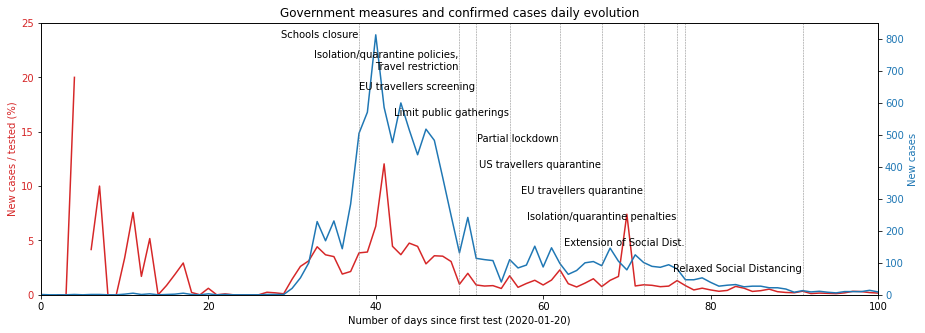

In [32]:
fig, ax1 = plt.subplots()

# Creating left-hand y-axis, plotting percentage of new cases per total tested cases
color = 'tab:red'
ax1.set_xlabel('Number of days since first test ({:})'.format(timedf.date.min().date()))
ax1.set_ylabel('New cases / tested (%)', color=color)
ax1.set_ylim([0, 25])
ax1.set_xlim([0,100])
ax1.plot(timedf.days_since0, timedf.conf_on_day/timedf.test_on_day*100, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating right-hand y-axis, plotting new cases per day
ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('New cases', color=color)
ax2.plot(timedf.days_since0, timedf.conf_on_day, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 850])

# Setting figure dimensions
fig.set_figheight(5)
fig.set_figwidth(15)

# Setting tile
plt.title('Government measures and confirmed cases daily evolution')

# Creating a step to annotate government measures in cascade style
step = timedf.conf_on_day.max()/len(govMeas)

# Setting initial place and iteratable one
init = timedf.conf_on_day.max()
current = timedf.conf_on_day.max() + step

# Making a vertical line and annotating its test on the left for each measure
for cat,day in zip(govMeas.MEASURE,govMeas.days_since0):
    current -= step
    plt.axvline(linewidth=0.5, color='gray',x=day,ls='--')
    plt.annotate(cat, xy=(day-0.1,current), verticalalignment='center', horizontalalignment='right',
                annotation_clip=True)
    
plt.show()

Okay, so what can we say about that plot? Like the butcher would say, let's go by parts (LOL):
* The government seem to have acted fast, by the next day that mass testing started, schools were closed;
* After this first action, 10 days of monitoring seem to have occured. Within those, although we can see a drastic reduction in new cases, the actions increase in frequency. Maybe it worked! Continuing seems like a good option;
* From around day 50, when isolation and quarantines policies were implemented, the curve is pretty much stable, with some noise, up until day 75;
* After day 75, the curve really starts going flat, enabling the government to, after a couple of weeks, implement relaxed social distancing, which does not seem to have caused a second wave up until day 101 (April 29th).

It is hard to pinpoint what action was the most efficient one in reducing the new cases of the disease, since you can expect to see a delay between actions and result, if any. Nevertheless, we can make the assumption that the control of the disease was a success, and was probably due to fast acting by the government and population awareness (when your government closes schools, you know it is a serious matter!).

## Geographical profile

So now that we have seen the dimension of the big numbers for the country as whole, let's focus on how the disease spread through the territory. The plot below shows a movie with the days that have had any update of information since day 1, and red spots represent, obviously, the biggest percentage of sick people in that moment, taking into account the whole territory. You can zoom-in and out, hover your mouse above red spots to see what provinces are that we are dealing with, and control the frames per second to make the movie go faster (around 5 is usually good for visualizing). 

In [33]:
locs = patRou.groupby('province').mean().reset_index()[['province','latitude','longitude']]

# Manually appending Sejong province, which was not on the dataset
locs = locs.append({'province' : 'Sejong' , 'latitude' : 36.560407, 'longitude':127.258044} , ignore_index=True)

In [34]:
# Creating a confirmed attribute from the other 3
df['Confirmed'] = df['state_deceased'] + df['state_isolated'] + df['state_released']

# Grouping by date and province
temp = df.groupby(['date','province']).sum().reset_index()[['province','date','state_deceased',
                                                            'state_isolated','state_released','Confirmed',]]

temp = temp.rename(columns={'state_deceased':'Deceased',
                                  'state_isolated':'Isolated',
                                  'state_released':'Released'})

df_plot = pd.DataFrame(columns=temp.columns)

# Getting the cumulative sum for each state by date and province
for province in temp.province.unique():
    temp2 = temp[temp['province']==province]
    temp2['Confirmed'] = temp2['Confirmed'].cumsum()
    temp2['Released'] = temp2['Released'].cumsum()
    temp2['Deceased'] = temp2['Deceased'].cumsum()
    temp2['Isolated'] = temp2['Isolated'].cumsum()
    df_plot = df_plot.append(temp2, ignore_index=True)

# Merging the locations with the data so that geo-plots are possible
df_plot = pd.merge(df_plot,locs,on='province',how='outer')
df_plot = df_plot.sort_values(by=['date'])

In [35]:
# list where, for each time, coordinates will have the amount of occurrences
df_time_list = []

# Adding both present and past numbers so that the spatio-temporal plot is not only a picture of the current moment,
# but rather and evolution that stores values from past times.
for time in df_plot.date.sort_values().unique():
    df_time_list.append(df_plot.loc[df_plot.date <= time, ['latitude', 'longitude', 'Confirmed']].groupby([
        'latitude','longitude']).sum().reset_index().values.tolist())

mapSK = folium.Map(location=(35.5,128), zoom_start=7, tiles='Stamen Terrain',height=600,widht=800)

# Adding circles to mark the provinces with hovering interactivity
for province in locs.province:
    folium.Circle(radius=1, location=[locs[locs['province']==province].latitude, 
                                        locs[locs['province']==province].longitude],
                  tooltip=province,color='crimson', fill=True,).add_to(mapSK)

# Create heatmap with movie
HeatMapWithTime(df_time_list, radius=45, gradient={0.2: 'blue', 0.4: 'lime', 0.7: 'orange', 1: 'red'},
                min_opacity=0.3, max_opacity=0.9, use_local_extrema=True).add_to(mapSK)

# Display movie
mapSK

Very cool! We can see that the first person diagnosed with COVID-19 was from Incheon. The disease then spreaded to Seoul, also popping more to the south. Around day 20 the hottest spot moves to Daegu, and then to a place right to the north of it. From day 30 the plot does not change much anymore, since most places are now varying by the same amount.

A more geeky way of looking at the same data, with more layers, can be seen below. Press play, sit back, and enjoy those bars moving around =D. Oh! Don't forget to hover your mouse over the bars to get all the data from that moment, like the number of isolated, released, deceased and confirmed people.

In [38]:
df_plot['date'] = pd.to_datetime(df_plot['date'], format='%Y-%m-%d')

In [39]:
df_plot = df_plot.set_index(['province', 'date']).reindex(pd.MultiIndex.from_product([df_plot['province'].unique(), df_plot['date'].unique()], 
                                       names=['province', 'date']))

In [40]:
df_plot = df_plot.groupby(level='province').ffill().dropna().sort_index(level='date').reset_index()

In [41]:
df_plot['Days'] = df_plot['date'].apply(lambda x: (x-df_plot.date.min()).days)

In [42]:
fig = px.bar(df_plot,x='province',y='Confirmed',animation_frame='Days',animation_group='province',
            hover_name='province',hover_data=['Confirmed','Isolated','Released','Deceased'],
            title='Confirmed cases of COVID-19 per province',opacity=0.75)

# Setting background to transparent
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)',
                   'paper_bgcolor': 'rgba(0, 0, 0, 0)',})

# Ordering bars and setting figure size
fig.update_layout(xaxis={'categoryorder':'total descending'},width=900,height=600)

# Not displaying axis labels
fig.update_yaxes(title_text='', automargin=True)
fig.update_xaxes(title_text='', tickfont=dict(size=10))

fig.show()

## What could have happened geographically?

The province that currently carries the biggest amount of cases historically is Gyeongsangbuk-do, and the magnitude is incredible, being more than the sum of the second and third largest focal points (Gyeonggi-do and Seoul). But what is so special (or, in this case, dangerous) about Gyeongsangbuk-do?

Upon closer inspection of the data that we have, we unfortunately can see a difference between those who we can trace the route and status, and those we can't. The table below shows that difference, which is not depicted in the geographical plots of before:

So Daegu actually contains more than 60% of the national cases!

According to http://nationalatlas.ngii.go.kr/pages/page_1266.php, Daegu is the second most population dense province (right after Seoul, the third worst hotspot) and has one of the busiest airports (https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_South_Korea#2017_final_statistics), while Gyeongsangbuk-do does not have any data amongst the busiest airports. Therefore, it seems as if Daegu could function as a centre for air travelling for the surrounding provinces.

The conclusion couldn't be more natural: avoiding densely populated areas and busy airports seem to be a good idea to reduce the risks of contracting the disease.